# Dissatisfuction Data Analysis_2

We calculated the magnitude of the correlation between each group by a multivariate Hawkes process. In addition, we visualized the propagation structure of posts in each group by summarizing the results in a Hawkes heat map. 
In conclusion, female workers raised many issues and they were strongly influenced by male workers.

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import numpy.linalg as LA
import random as r
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import itertools

data = pd.read_csv('gender_data_12.csv', encoding="utf-8")

Put the data into the input form of a point process.

input data: np.array( [ [t_1, dim_1], ..., [t_n, dim_n] ] )

In [4]:
arrivals = []

for i in range(1, 13):
    arrivals.append([0, i])

for i in range(1, data.shape[0]):
    arrivals.append([data["created_at_unix"][i], data["label"][i]])

arrivals = np.array(arrivals)
arrivals[:10]

array([[ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  3.],
       [ 0.,  4.],
       [ 0.,  5.],
       [ 0.,  6.],
       [ 0.,  7.],
       [ 0.,  8.],
       [ 0.,  9.],
       [ 0., 10.]])

Since what we are interested in is the stationary mechanism of posting, we analyzed data from when the service was stable.

In [5]:
num = sum(arrivals.T[0]<400)
arrivals = arrivals[num:] - np.array([arrivals[num][0], 0])
arrivals[:10]

array([[ 0.        , 11.        ],
       [ 0.01208333,  3.        ],
       [ 0.01449074,  5.        ],
       [ 0.0262963 ,  3.        ],
       [ 0.04824074,  4.        ],
       [ 0.08018519,  3.        ],
       [ 0.13984954,  2.        ],
       [ 0.28568287,  2.        ],
       [ 0.35184028,  4.        ],
       [ 0.37804398, 12.        ]])

Examples.

In [6]:
r.seed(0)
np.set_printoptions(threshold=np.inf)
idx = sorted(r.sample(range(len(arrivals)), 8))
start = len(data) - len(arrivals)
for i in idx:
    print("id: ", i)
    print("created_at: ", list(data[data.index==start+i]["created_at"])[0])
    print("gender: ", list(data[data.index==start+i]["gender"])[0])
    print("birth: ", list(data[data.index==start+i]["birth"])[0])
    print("label: ",list(data[data.index==start+i]["label"])[0])
    print("text: ",list(data[data.index==start+i]["text"])[0], "\n")

id:  663
created_at:  2016-05-16 16:18:35.495644
gender:  男
birth:  1977.0
label:  9
text:  自分には甘いが相手のことになると相手を貶めるためだけに男尊女卑とか差別とか軽々しく使うのやめてほしい。コメンテーターレベルの議員は特に税金の無駄なんでやめてほしい。 

id:  4242
created_at:  2016-09-28 12:09:26.361833
gender:  女
birth:  1996.0
label:  2
text:  テレビでのオネェキャラへのいじりや流行り物のように男装女装を取り上げる限り日本のセクシャルマイノリティに対する理解は広まるどころか間違った方向に行くのではないかなと不安。服装、体、心、性対象を男性か女性かの二種類のどちらかに統一するものだという考えは間違えている。まずはメディアがきちんとした知識をつけて欲しい 

id:  4969
created_at:  2016-10-24 02:40:23.352887
gender:  女
birth:  1988.0
label:  2
text:  外国人選手へのインタビューを吹き替えする時に、女性選手の言葉の語尾を「〜わよ」「〜のよ」「〜わ」、男性選手の言葉の語尾を「〜なんだ」「〜だよ」などと訳すのをやめて欲しい。日本人が話しているような言葉遣いで表現してほしい。 

id:  6311
created_at:  2016-12-13 21:14:41.288605
gender:  男
birth:  1973.0
label:  10
text:  他の男に取られるくらいなら殺そうと思った
打倒だと思う 身勝手な女が多すぎる 

id:  6634
created_at:  2016-12-27 11:56:22.416393
gender:  男
birth:  1980.0
label:  9
text:  美容院の店員がチャライ。男性店員は女性客には本当にチャラく見える。 

id:  6890
created_at:  2017-01-08 06:40:16.121593
gender:  男
birth:  1976.0
label:  10
text:  女性ばっかりファ

We define the quasi log-likelihood process and the quasi log-likelihood process with $L^1$-penalty.

In [33]:
def kernel(t, s, i, j, params):
    dim = int((np.sqrt(8*len(params)+1)-1)/4)
    beta = np.array(params[(dim+dim**2):]).reshape((dim, dim))
    kernel = np.exp(-beta[i][j]*(t - s))
    return kernel
def loglik(params, arrivals):
    dim = int((np.sqrt(8*len(params)+1)-1)/4)
    mu = np.array(params[:dim])
    alpha = np.array(params[dim:(dim+dim**2)]).reshape((dim, dim))
    beta = np.array(params[(dim+dim**2):]).reshape((dim, dim))
    t_max = arrivals[-1][0]
    
    ep = 1/t_max**2
    mu = mu + ep 

    loglik = []
    time = []

    # dim iのジャンプ時刻(0とt_maxは除く)
    for i in range(dim):
        time.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])

    # loglik_iを計算していく
    for i in range(dim):
        Ai = 0 # log( intensity^i_{t[i][z]} ) = log( mu[i] + sum_{j=1 ...,dim} sum_{k : t[i][z] > t[j][k]} alpha[i][j]*exp(-beta[i][j]*(t[i][z]-t[j][k])) )
        Bi = 0 # sum_{k=0,...,t[j][-1]} (alpha[i][j]/beta[i][j])*(exp(-beta[i][j]*(t_max-t[j][k])) -1)

        for z in range(len(time[i]))[:-1]:
            intensity = mu[i]
            for j in range(dim):
                intensity += alpha[i][j]*np.sum(kernel(time[i][z], time[j][time[j][:]<time[i][z]] ,i ,j, params))
            Ai += np.log(intensity) #intensity=0の時は0
           
        for j in range(dim):
            Bi += (-1)*(alpha[i][j]/beta[i][j])*np.sum(kernel(t_max, time[j][:-1] ,i , j, params)-1)

        loglik.append( Ai - ( mu[i]*t_max + Bi ))
        
    return (-1)*np.sum(loglik)
def Lasso_loglik(params, arrivals):
    dim = int((np.sqrt(8*len(params)+1)-1)/4)
    mu = np.array(params[:dim])
    alpha = np.array(params[dim:(dim+dim**2)]).reshape((dim, dim))
    beta = np.array(params[(dim+dim**2):]).reshape((dim, dim))
    t_max = arrivals[-1][0]
    
    ep = 1/t_max**2
    mu = mu + ep 

    loglik = []
    time = []

    # dim iのジャンプ時刻(0とt_maxは除く)
    for i in range(dim):
        time.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])

    # loglik_iを計算していく
    for i in range(dim):
        Ai = 0 # log( intensity^i_{t[i][z]} ) = log( mu[i] + sum_{j=1 ...,dim} sum_{k : t[i][z] > t[j][k]} alpha[i][j]*exp(-beta[i][j]*(t[i][z]-t[j][k])) )
        Bi = 0 # sum_{k=0,...,t[j][-1]} (alpha[i][j]/beta[i][j])*(exp(-beta[i][j]*(t_max-t[j][k])) -1)

        for z in range(len(time[i]))[:-1]:
            intensity = mu[i]
            for j in range(dim):
                intensity += alpha[i][j]*np.sum(kernel(time[i][z], time[j][time[j][:]<time[i][z]] ,i ,j, params))
            Ai += np.log(intensity) #intensity=0の時は0
           

        for j in range(dim):
            Bi += (-1)*(alpha[i][j]/beta[i][j])*np.sum(kernel(t_max, time[j][:-1] ,i , j, params)-1)

        loglik.append( Ai - ( mu[i]*t_max + Bi ))
        
    return (-1)*np.sum(loglik) + np.sqrt(t_max)*np.sum(np.array(params[:(dim+dim**2)]))
def True_loglik(params, arrivals):
    dim = int((np.sqrt(8*len(params)+1)-1)/4)
    mu = np.array(params[:dim])
    alpha = np.array(params[dim:(dim+dim**2)]).reshape((dim, dim))
    beta = np.array(params[(dim+dim**2):]).reshape((dim, dim))
    t_max = arrivals[-1][0]

    loglik = []
    time = []

    # dim iのジャンプ時刻(0とt_maxは除く)
    for i in range(dim):
        time.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])

    # loglik_iを計算していく
    for i in range(dim):
        Ai = 0 # log( intensity^i_{t[i][z]} ) = log( mu[i] + sum_{j=1 ...,dim} sum_{k : t[i][z] > t[j][k]} alpha[i][j]*exp(-beta[i][j]*(t[i][z]-t[j][k])) )
        Bi = 0 # sum_{k=0,...,t[j][-1]} (alpha[i][j]/beta[i][j])*(exp(-beta[i][j]*(t_max-t[j][k])) -1)

        for z in range(len(time[i]))[:-1]:
            intensity = mu[i]
            for j in range(dim):
                intensity += alpha[i][j]*np.sum(kernel(time[i][z], time[j][time[j][:]<time[i][z]] ,i ,j, params))
            Ai += np.log(intensity) #intensity=0の時は0
           
        for j in range(dim):
            Bi += (-1)*(alpha[i][j]/beta[i][j])*np.sum(kernel(t_max, time[j][:-1] ,i , j, params)-1)

        loglik.append( Ai - ( mu[i]*t_max + Bi ))
        
    return (-1)*np.sum(loglik)

We define a function to display the result.

In [34]:
def result_show(res, round=3):
    np.set_printoptions(suppress=True)
    mle = np.round(res.x, round)
    dim = int((np.sqrt(8*len(mle)+1)-1)/4)

    mu = np.array(mle[:dim])
    alpha = np.array(mle[dim:(dim+dim**2)]).reshape((dim, dim))
    beta = np.array(mle[(dim+dim**2):]).reshape((dim, dim))

    print("mu: ")
    print(mu)

    print("alpha: ")
    print(alpha)

    print("beta: ")
    print(beta)

    print("alpha/beta: ")
    print(alpha/beta)
    
    print( "\n")
    
    print("Spectral radius", end=": ")
    print(max(abs(LA.eig(alpha/beta)[0])))

    x = np.repeat(0, dim)

    mle_orig = list([mu, alpha, beta, x])

    return mle_orig

Initial values and boundaries of the parameters in the optimization.

In [8]:
dim = 12
params_num = dim+2*dim**2

#Initial values 
mu = np.ones(dim)
alpha = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0 + 0.1
beta = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0 + 2

params = mu.reshape(1, -1).tolist()[0]
params[len(params):len(params)] = alpha.reshape(1, -1).tolist()[0]
params[len(params):len(params)] = beta.reshape(1, -1).tolist()[0]

print("Spectral radius", end=": ")
print(max(abs(LA.eig(alpha/beta)[0])))

Spectral radius: 0.5999999999999999


In [9]:
#Boundaries
low_bd = [0]*(dim)
low_bd[len(low_bd):len(low_bd)] = [0]*(dim**2)
low_bd[len(low_bd):len(low_bd)] = [1.e-5]*(dim**2)
up_bd = [1.e+4]*params_num
bounds = optimize.Bounds(low_bd, up_bd)

## Estimation (MLE)

In [11]:
t1 = time.time()
mle_res = optimize.minimize(fun=loglik, x0=np.array(params), args=arrivals, method='L-BFGS-B', bounds=bounds)
t2 = time.time()
elapsed_time = t2-t1
print(f"elapsed_time：{elapsed_time}")

経過時間：54022.07091093063


In [12]:
print("success : " + str(mle_res["success"]) + "\n")
mle = result_show(mle_res,round=4)
pd.DataFrame(mle_res.x).to_csv("mle_res_gender_over400_12.csv")

success : False

mu: 
[0.     0.8781 1.3769 0.7555 0.6602 0.1923 0.     0.     0.169  0.3369
 0.     0.    ]
alpha: 
[[0.5802 0.0061 0.0407 0.     0.     0.0012 0.0706 0.     0.0111 0.
  0.     0.0245]
 [0.204  0.3536 0.3438 0.0702 0.6082 0.2913 0.1226 0.2839 0.     0.4557
  0.3691 0.1837]
 [0.0386 0.808  0.8544 0.7738 0.6363 0.3956 0.1562 0.2186 0.1507 0.6377
  0.2443 0.145 ]
 [0.3294 0.5379 0.5818 0.1635 0.3396 0.4487 0.2395 0.4235 0.3605 0.3751
  0.3329 0.1539]
 [0.1546 0.0536 0.1345 0.     0.1697 0.     0.1264 0.3142 0.0734 0.051
  0.     0.0717]
 [0.1437 0.0201 0.0038 0.0005 0.0089 0.2517 0.     0.0388 0.     0.0127
  0.088  0.1921]
 [0.1734 0.     0.0116 0.     0.0796 0.2522 0.     0.     0.0195 0.
  0.0235 0.    ]
 [0.     0.095  0.0768 0.0918 0.0882 0.     0.0616 0.0009 0.0902 0.309
  0.     0.1885]
 [0.1442 0.1593 0.1804 0.2098 0.3234 0.     0.1298 0.0463 0.2385 0.0009
  0.1561 0.1253]
 [0.1048 0.     0.047  0.0046 0.2031 0.0257 0.0354 0.0133 0.0204 0.3125
  0.3375 0.3336]
 [0

## Estimation (LASSO)

In [19]:
t1 = time.time() 
#res_Lasso = optimize.minimize(fun=Lasso_loglik, x0=np.array(params), args=arrivals, method='L-BFGS-B', bounds=bounds)
res_Lasso = optimize.minimize(fun=Lasso_loglik, x0=pre_LASSO, args=arrivals, method='L-BFGS-B', bounds=bounds)
t2 = time.time()
elapsed_time = t2-t1
print(f"elapsed_time：{elapsed_time}")

経過時間：36700.19587779045


In [21]:
print("success : " + str(res_Lasso["success"]) + "\n")
Lasso = result_show(res_Lasso,round=4)
pd.DataFrame(res_Lasso.x).to_csv("2nd_Lasso_res_gender_over400_12.csv")

success : False

mu: 
[0.     0.0392 0.2324 0.     0.0902 0.1542 0.     0.     0.     0.3842
 0.     0.    ]
alpha: 
[[0.2347 0.     0.0354 0.     0.     0.     0.     0.     0.0385 0.
  0.0284 0.    ]
 [0.     0.2679 0.2983 0.093  0.3188 0.     0.     0.     0.     0.0397
  0.     0.    ]
 [0.     0.3231 0.5943 0.3828 0.1659 0.     0.     0.     0.     0.
  0.     0.    ]
 [0.     0.4687 0.591  0.316  0.3261 0.     0.     0.0044 0.3151 0.004
  0.     0.    ]
 [0.     0.1222 0.202  0.0074 0.0653 0.     0.     0.1038 0.1162 0.
  0.     0.    ]
 [0.     0.0818 0.0256 0.0094 0.     0.0426 0.     0.     0.     0.0015
  0.0393 0.    ]
 [0.0018 0.0223 0.0044 0.     0.0197 0.0056 0.     0.     0.062  0.
  0.0745 0.    ]
 [0.     0.0524 0.0907 0.0568 0.1484 0.     0.     0.     0.1616 0.1303
  0.     0.    ]
 [0.     0.1971 0.1861 0.2615 0.2185 0.     0.     0.     0.1433 0.
  0.     0.    ]
 [0.     0.017  0.0543 0.0515 0.1321 0.     0.     0.     0.0008 0.089
  0.1258 0.    ]
 [0.     0.0887

## Plot

In [38]:
## Define the function X
## X_new = exp{-beta*s} * X_old
## s : time interarrival, X : each old intensity component
def X_gene(s, X, params):
    beta = params[2]
    X = np.exp((-s)*beta) * X
    return X

############################################################################
############################################################################

## Simulate Hawkes time series
def simulate_mlt_hawkes(params, t_max):
    mu = params[0]
    alpha = params[1]
    beta = params[2]
    x = params[3]
    dim = len(mu)

    # each jump times (t_{i,0} = 0 for all i)
    arrivals = np.array([[0,1]])
    for i in range(1,dim):
        arrivals = np.append(arrivals, np.array([[0,i+1]]), axis=0)

    s = 0 # time interarrival
    t = 0 # jump time

    ### Case: a first jump
    # Calculate now intensity at t = 0
    # and consider the 1-dim P.P. with intensity lambda_bar
    lambda_bar = np.sum(mu + x)
    s = -np.log(r.random())/lambda_bar
    t = t + s
    if t>t_max:
        for i in range(dim):
            arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
        return arrivals

    # Define X for calculating now intensity
    rho = ((alpha/beta).T/np.sum(alpha/beta, axis=1)).T
    X = (rho.T*x).T
    X = X_gene(s, X, params)
    # calculate now intensity at t = s-
    intensity = mu + np.sum(X, axis=1)

    ## Searching for which dimension a jump is occuring in
    D = r.random()
    cum_lambda = np.sum(intensity)
    if D*lambda_bar<cum_lambda:
        # Searching for the first k such that D*lambda <= cum_lambda_k
        k = 1
        cum_lambda_k = np.sum(intensity[:k])
        while D*lambda_bar>cum_lambda_k:
            k += 1
            cum_lambda_k = np.sum(intensity[:k])
        arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
    else:# there are no jumps
        k = 0

    ### Case: other jumps
    while t < t_max:
        # Calculate now intensity at t = t+
        # and consider the 1-dim P.P. with intensity lambda_bar
        if k!=0:
            X[:,k-1] = X[:,k-1] + alpha[:,k-1]

        lambda_bar = np.sum(mu + np.sum(X, axis=1))
        s = -np.log(r.random())/lambda_bar
        t = t + s

        if t > t_max:
            for i in range(dim):
                arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
            return arrivals

        # calculate now intensity at t = t + s-
        X = X_gene(s, X, params)
        intensity = mu + np.sum(X, axis=1)

        ## Searching for which dimension a jump is occuring in
        D = r.random()
        cum_lambda = np.sum(intensity)
        if D*lambda_bar<cum_lambda:
            # Searching for the first k such that D*lambda <= cum_lambda_k
            k = 1
            cum_lambda_k = np.sum(intensity[:k])
            while D*lambda_bar>cum_lambda_k:
                k += 1
                cum_lambda_k = np.sum(intensity[:k])
            arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
        else:# there are no jumps
            k = 0

    for i in range(dim):
        arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)

    return arrivals

In [40]:
def X_gene(s, X, params):
    beta = params[2]
    X = np.exp((-s)*beta) * X
    return X

def intensity(params, arrivals, delta):
    mu = params[0]
    alpha = params[1]
    beta = params[2]
    x = params[3]
    dim = len(mu)

    # Intensity seq
    intensity = np.array([[(mu+x)[0], 0, 1]]) # [intensity, time, dim]
    if dim > 1:
        for i in range(1,dim):
            intensity = np.append(intensity, [[(mu+x)[i], 0, i+1]], axis=0)

    # 最初のintervalはXを所与の初期値から計算する # x=0ならばX=０
    rho = ((alpha/beta).T/np.sum(alpha/beta, axis=1)).T
    X = (rho.T*x).T

    # 最初と最後は打点がdim個だけ被っているため，取り除いて考える
    for i in range(dim-1, len(arrivals)-(dim-1)-1):
        # intervalを間隔deltaで刻む
        t_seq = np.arange(arrivals[i][0], arrivals[i+1][0], delta)

        # intensityを計算
        for k in range(len(t_seq)):
            X_now = X_gene(t_seq[k]-arrivals[i][0], X, params)
            intensity = np.append(intensity,
                            np.array([
                                mu + np.sum(X_now, axis=1),
                                np.repeat(t_seq[k], dim),
                                range(1,dim+1)
                                ]).T,
                            axis=0)
        # seqで間引かれるため，最後の点は別途計算
        X = X_gene(arrivals[i+1][0]-arrivals[i][0], X, params)
        intensity = np.append(intensity,
                        np.array([
                            mu + np.sum(X_now, axis=1),
                            np.repeat(arrivals[i+1][0], dim),
                            range(1,dim+1)
                        ]).T,
                        axis=0)

        # Xの更新
        X[:,int(arrivals[i][1]-1)] = X[:,int(arrivals[i][1]-1)] + alpha[:,int(arrivals[i][1]-1)]

    return(intensity)

def Hawkes_plot(arrivals, params, delta):
    mu = params[0]
    alpha = params[1]
    beta = params[2]

    # plot用の画面分割
    dim = len(params[0])
    fig = plt.figure(figsize=(20, 8))
    plt.subplots_adjust(hspace=0,wspace=0.3)
    gs = gridspec.GridSpec(2,dim)

    # Simulation p.p.
    t = arrivals

    # Simulation intensity
    l = intensity(params, t, delta)

    for i in range(dim):
        #print("dimension", end=": ")
        #print(i+1)

        time = t[t.T[:][1]==i+1]
        time = time.T[:][0]
        #print("t", end="= ")
        #print(time)

        N = np.append(np.array(range(len(time)-1)), len(time)-2)
        #print("N_t", end="= ")
        #print(N)

        ax = fig.add_subplot(gs[0,i])
        plt.subplot(gs[0,i])
        ax.plot(time, N,  color='red', drawstyle='steps-post')
        plt.ylabel("$N^{%d}$" %(i+1))
        ax.grid()

        lambda_i = l[l.T[:][2]==i+1]
        time = lambda_i.T[:][1]
        lambda_i = lambda_i.T[:][0]

        ax = fig.add_subplot(gs[1,i])
        plt.subplot(gs[1,i])
        ax.plot(time, lambda_i,  color='blue')
        ax.axhline(mu[i], ls = "-.", color = "magenta")
        plt.ylabel("$\lambda^{%d}$" %(i+1))
        plt.xlabel("time")
        ax.grid()

    fig.suptitle('Exp Hawkes Plot', fontsize=20)
    plt.show()
    
def Hawkes_mlt_plot(arrivals, params, t_max, delta, M, plt_title, file_name):
    label = ["f 0~19", "f 20~29", "f 30~39", "f 40~49", "f 50~59", "f 60~", "m 0~19", "m 20~29", "m 30~39", "m 40~49", "m 50~59", "m 60~"]

    mu = params[0]
    alpha = params[1]
    beta = params[2]

    # plot用の画面分割
    dim = len(params[0])
    fig = plt.figure(figsize=(20, 10))
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    gs = gridspec.GridSpec(2,dim//2)

    for n in range(M):
        # Simulation p.p.
        t = simulate_mlt_hawkes(params, t_max)

        for i in range(dim//2):
            time = t[t.T[:][1]==i+1]
            time = time.T[:][0]

            N = np.append(np.array(range(len(time)-1)), len(time)-2)

            ax = fig.add_subplot(gs[0,i])
            plt.subplot(gs[0,i])
            if n == 0:
                ax.plot(time, N,  color='green', drawstyle='steps-post', alpha=0.4, label='Simulation')
            else:
                ax.plot(time, N,  color='green', drawstyle='steps-post', alpha=0.4)
        
        for i in range(dim//2, dim):
            time = t[t.T[:][1]==i+1]
            time = time.T[:][0]

            N = np.append(np.array(range(len(time)-1)), len(time)-2)

            ax = fig.add_subplot(gs[1,i-dim//2])
            plt.subplot(gs[1,i-dim//2])
            if n == 0:
                ax.plot(time, N,  color='green', drawstyle='steps-post', alpha=0.4, label='Simulation')
            else:
                ax.plot(time, N,  color='green', drawstyle='steps-post', alpha=0.4)

            
    t = arrivals
    
    for i in range(dim//2):
        time = t[t.T[:][1]==i+1]
        time = time.T[:][0]

        N = np.append(np.array(range(len(time)-1)), len(time)-2)

        ax = fig.add_subplot(gs[0,i])
        plt.subplot(gs[0,i])
        ax.plot(time, N,  color='red', drawstyle='steps-post', label='Data')
        plt.ylabel("$N_t^{%d}$ " %(i+1),fontsize=12)
        plt.xlabel("$t$ "+"(day)",fontsize=12)
        ax.set_title("Group %d " %(i+1) + label[i],fontsize=15)
        plt.subplots_adjust(top=0.9)
        ax.grid()
        ax.legend()
        
    for i in range(dim//2, dim):
        time = t[t.T[:][1]==i+1]
        time = time.T[:][0]

        N = np.append(np.array(range(len(time)-1)), len(time)-2)

        ax = fig.add_subplot(gs[1,i-dim//2])
        plt.subplot(gs[1,i-dim//2])
        ax.plot(time, N,  color='red', drawstyle='steps-post', label='Data')
        plt.ylabel("$N_t^{%d}$ " %(i+1),fontsize=12)
        plt.xlabel("$t$ "+"(day)",fontsize=12)
        ax.set_title("Group %d " %(i+1) + label[i],fontsize=15)
        plt.subplots_adjust(top=0.9)
        ax.grid()
        ax.legend()
        
    fig.suptitle(plt_title, fontsize=25)
    plt.savefig(file_name)
    plt.show()

### MLE

In [19]:
mu = mle[0]
alpha =mle[1]
beta = mle[2]
x = np.zeros(12)

mle_params =list([mu, alpha, beta, x])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


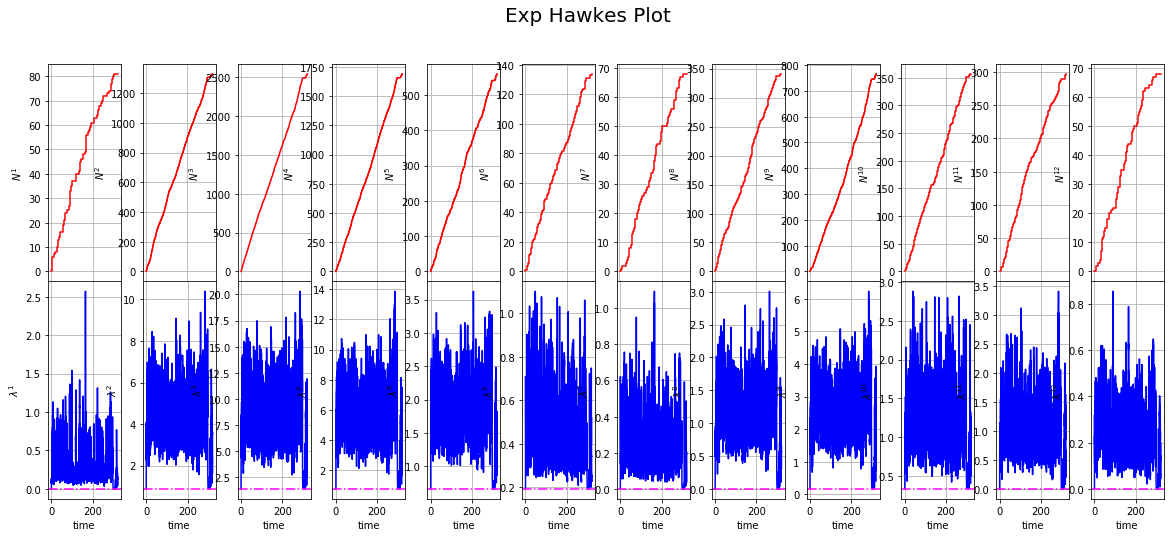

In [20]:
t_max = arrivals[:][-1][0]
delta = 1/100
Hawkes_plot(arrivals, mle_params, delta)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

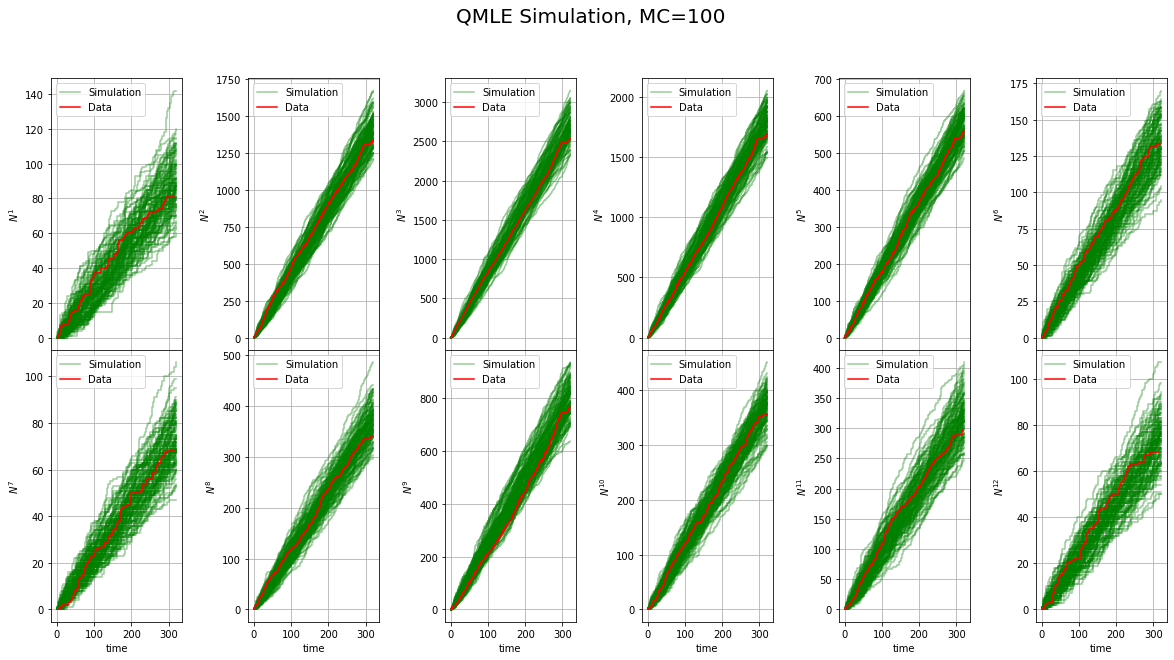

In [21]:
Hawkes_mlt_plot(arrivals, mle_params, t_max, delta, 100, "QMLE Simulation, MC=100", "result_sim_mle_12.png")

### LASSO

In [22]:
mu = Lasso[0]
alpha = Lasso[1]
beta = Lasso[2]
x = np.zeros(12)

LASSO_params =list([mu, alpha, beta, x])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


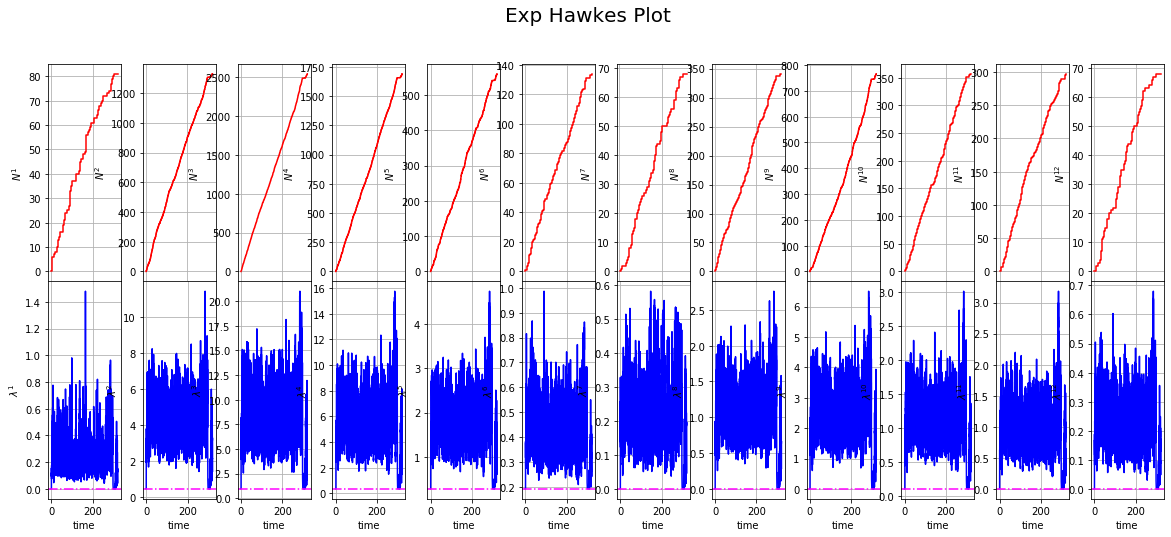

In [23]:
t_max = arrivals[:][-1][0]
delta = 1/100
Hawkes_plot(arrivals, LASSO_params, delta)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

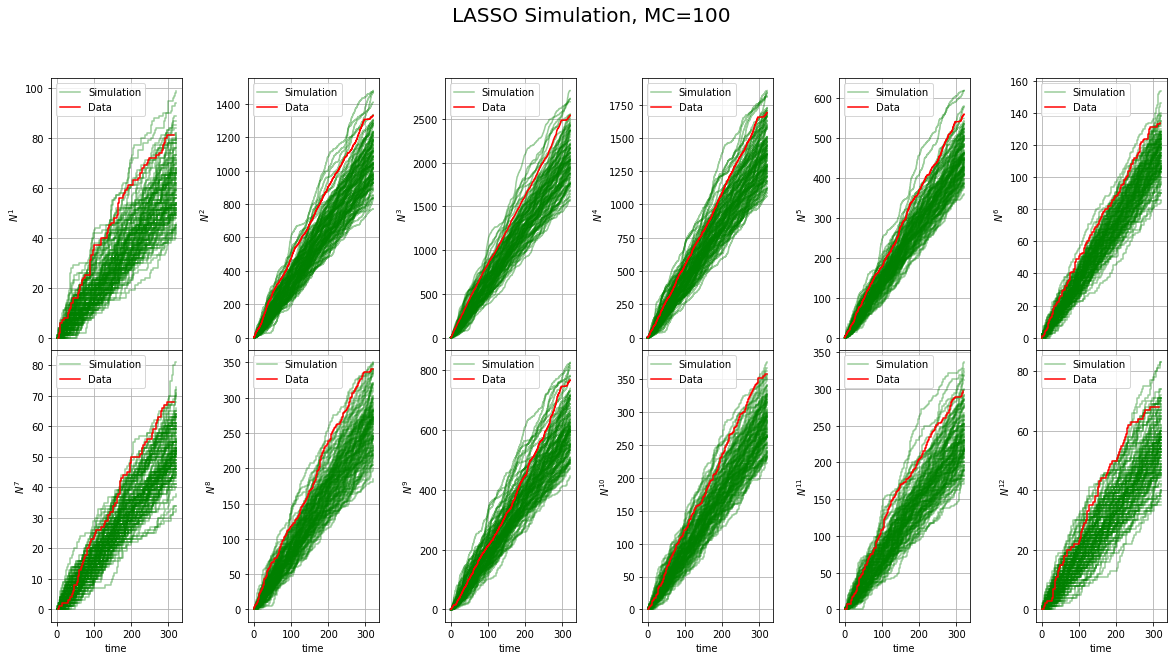

In [24]:
Hawkes_mlt_plot(arrivals, LASSO_params, t_max, delta, 100, "LASSO Simulation, MC=100", "result_sim_LASSO_12.png")

## LASSO+QMLE
After estimation for parameters in the 12-dimensional Hawkes process by the LASSO, we re-estimated the non-zero parameters by the QMLE.

In [90]:
# given paramをstrで与えておく
def param_gene(params):
    mu = params[0]
    alpha = params[1]
    beta = params[2]
    dim = len(mu)

    given=[[],[],[]]
    mu_id = []
    alpha_id =[]
    beta_id = []
    
    for i in range(dim):
        if type(mu[i]) == str:
            given[0].append([i+1, float(mu[i])])
            mu_id.append(i)
            
    for i in range(dim):
        for j in range(dim):
            if type(alpha[i][j]) == str:
                given[1].append([i+1, j+1, float(alpha[i][j])])
                alpha_id.append(i*dim+j)
            if type(beta[i][j]) == str:
                given[2].append([i+1, j+1, float(beta[i][j])])
                beta_id.append(i*dim+j)

    mu = np.delete(mu, mu_id)
    alpha = list(map(lambda a: float(a), itertools.chain.from_iterable(alpha)))
    alpha = np.delete(alpha, alpha_id)
    beta = list(map(lambda b: float(b), itertools.chain.from_iterable(beta)))
    beta = np.delete(beta, beta_id)
   
    cparams = mu
    cparams = np.append(cparams, alpha)
    cparams = np.append(cparams, beta)
    return cparams, given

def re_params(cparams, given, dim):
    for i in range(3):
        if given[i]==[]:
            continue
        for cns in sorted(given[i]):
            if i==0:
                cparams = np.insert(cparams, cns[0]-1, cns[-1])
            elif i==1:
                cparams = np.insert(cparams, dim+dim*(cns[0]-1)+(cns[1]-1), cns[-1])
            else:
                cparams = np.insert(cparams, dim+dim**2+dim*(cns[0]-1)+(cns[1]-1), cns[-1])
    return cparams

# given = [[[1,2]],[[1,2,0.1]],[[1,2,1], [2,2,0.5]]]
# mu_1=2, alpha_{12}=0.1, beta_{12}=1, beta_{22}=0.5
# arg = [arrivals, dim, given]
def cloglik(cparams, arg):
    arrivals = arg[0]
    dim = arg[1]
    given = arg[2]
    cparams = re_params(cparams, given, dim)
    return loglik(cparams, arrivals)

In [91]:
dim = 12
new_mu = LASSO_params[0].tolist()
new_alpha = LASSO_params[1].tolist()
new_beta = LASSO_params[2].tolist()
for i in range(dim):
    if new_mu[i]==0:
        new_mu[i]='0.'
for i in range(dim):
    for j in range(dim):
        if new_alpha[i][j]==0:
            new_alpha[i][j]='0.'
            new_beta[i][j]='1.'
new_params = [new_mu, new_alpha, new_beta]

In [92]:
cparams, given = param_gene(new_params)
print("cparams : ", cparams, "\n given : ", given)

cparams :  ['0.4316' '0.945' '0.3415' '0.2826' '0.1913' '0.1112' '0.2942' '0.0022'
 '0.0408' '0.0369' '0.0004' '0.4014' '0.471' '0.182' '0.352' '0.0007'
 '0.023' '0.8022' '0.9568' '0.8354' '0.2641' '0.1196' '0.6153' '0.7623'
 '0.3316' '0.0517' '0.0091' '0.2252' '0.001' '0.1224' '0.2339' '0.0867'
 '0.0279' '0.1053' '0.0751' '0.0151' '0.0122' '0.0001' '0.0089' '0.0191'
 '0.0071' '0.072' '0.0668' '0.0505' '0.0042' '0.0758' '0.1055' '0.0895'
 '0.0795' '0.0763' '0.133' '0.189' '0.2283' '0.2604' '0.185' '0.1647'
 '0.0438' '0.108' '0.047' '0.1514' '0.0062' '0.1519' '0.1779' '0.0506'
 '0.1215' '0.0165' '0.0819' '0.072' '0.2923' '0.0483' '0.0255' '0.0207'
 '0.0024' '0.001' '1.9827' '2.0468' '2.1118' '2.0261' '2.0103' '1.889'
 '1.9559' '1.9964' '1.9488' '2.0013' '1.9842' '1.9657' '2.9058' '2.057'
 '1.9774' '1.9726' '2.008' '2.3719' '2.1197' '1.9951' '1.9928' '1.9822'
 '1.9981' '1.9756' '1.9973' '2.0038' '1.9884' '1.9853' '2.0345' '2.0799'
 '2.0076' '2.0022' '2.0044' '2.0482' '2.0933' '2.0189' '2

In [93]:
#Boundaries
new_params_num = len(cparams)
new_beta_num = dim**2-len(given[2])
low_bd = [0]*(new_params_num-new_beta_num)
low_bd[len(low_bd):len(low_bd)] = [1.e-5]*(new_beta_num)
up_bd = [1.e+4]*new_params_num
bounds = optimize.Bounds(low_bd, up_bd)

In [94]:
t1 = time.time() 
res_QMLE_2nd = optimize.minimize(fun=cloglik, x0=np.array(cparams, dtype=float), args=[arrivals, dim, given], method='L-BFGS-B', bounds=bounds)
t2 = time.time()
elapsed_time = t2-t1
print(f"elapsed_time：{elapsed_time}")

経過時間：34217.282838106155


In [95]:
print("success : " + str(res_QMLE_2nd["success"]) + "\n")
p = re_params(res_QMLE_2nd.x, given, dim)
print("mu : ", np.array(p[:dim]))
print("alpha : ", np.array(p[dim:(dim+dim**2)]).reshape((dim, dim)))
print("beta : ", np.array(p[(dim+dim**2):]).reshape((dim, dim)))
pd.DataFrame(p).to_csv("2ndQMLE_res_gender_over400_12.csv")

success : False

mu :  [0.         0.74415861 1.94133582 0.0402886  0.62926862 0.24210943
 0.         0.         0.         0.26271423 0.         0.        ]
alpha :  [[0.38893686 0.00627059 0.04689064 0.         0.         0.
  0.         0.         0.00971239 0.         0.04332652 0.        ]
 [0.         0.31919542 0.39219082 0.11138141 0.50586468 0.
  0.         0.         0.1068398  0.60059367 0.         0.        ]
 [0.         0.30460751 1.57962722 0.16859621 0.56812725 0.
  0.         0.         0.         1.66730373 0.         0.        ]
 [0.         0.89137292 1.07335238 0.42894765 0.35162155 0.
  0.         1.02129623 0.4986324  0.76918965 0.         0.        ]
 [0.         0.03429194 0.18536263 0.         0.25928222 0.
  0.         0.19895993 0.08744686 0.         0.         0.        ]
 [0.         0.03235494 0.00125838 0.         0.         0.25801153
  0.         0.         0.         0.         0.13464577 0.        ]
 [0.13340653 0.02029116 0.00244923 0.         0.102

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artist

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

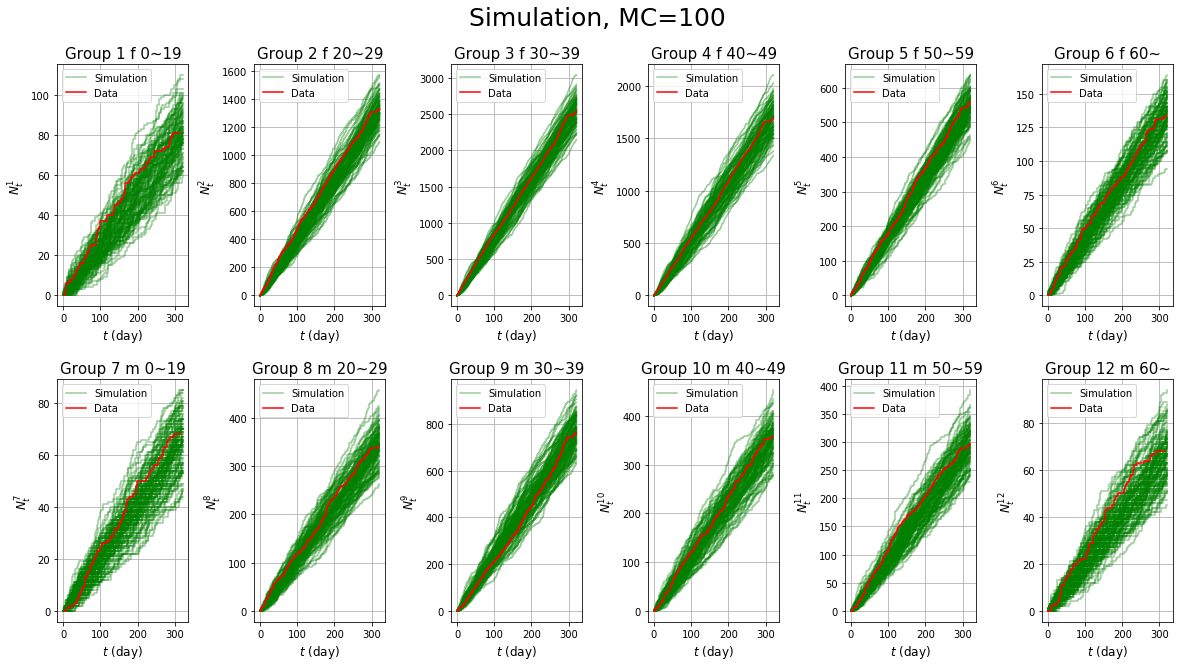

In [41]:
est_pass = '/Users/goda/Desktop/Dissatisfaction/gender/2ndQMLE_res_gender_over400_12.csv'
est = pd.read_csv(est_pass)['0']
dim=12
est_mu = np.array(est[:dim])
est_alpha = np.array(est[dim:(dim+dim**2)]).reshape((dim, dim))
est_beta = np.array(est[(dim+dim**2):]).reshape((dim, dim))
x = np.zeros(dim)

t_max = arrivals[:][-1][0]
delta = 1/100

r.seed(0)
Hawkes_mlt_plot(arrivals, [est_mu,est_alpha, est_beta,x], t_max, delta, 100, "Simulation, MC=100", "result_sim_2ndQMLE_12.eps")